# **RECOVERING LABELS FROM AGGREGATED GRADIENTS**

You can also find the same version to read on kaggle [HERE](https://www.kaggle.com/code/delbic/2-5-datasafetyv2)

# 1. Federated Learning and its guarantees

In the previous experiments I (wrongfully) assumed that Federated Learning$^1$ actually respects its privacy guarantees; I mean, we chose Federated Learning because we were in need of a technique that allowed us to train models while keeping our private data safe right?

Well, this is the truth only in an hypotethical fantasy world where everything is sunshine and rainbows (spoiler, it's not).

Remember what we said in the first notebook?

> Without getting too much into the details, each client has its own local training dataset (images, text...), which is never uploaded to the server; instead, each client computes an update to the current global model mantained by the server, and only this update is communicated (this does mean that some trust of the server coordinating the training is still required, we'll see why in 2.5_DataSafety).

> By using this decentralized approach we significantly decrease the risks associated with normal learning methods by limiting the attack surface to only one device (the client side) instead of both the device and the cloud.

Well, Federated Learning obviously was an incredible advancement, such that many researchers tried to test these privacy guarantees; it turns out that there are many, many ways to circumvent the fact that we utilize a decentralized system, most of which are cleverly engineered to work exactly on the final global model's output!

The attack methods are almost too many to count, but we can mention a few notable ones:
1. Membership Inference Attacks (leaks whether a specific data point or user participated in training)
2. Property Inference Attacks (leaks statistical properties of a client’s dataset)
3. Model Poisoning (leaks information about other clients’ data, meaning it does require a malicious client)
4. Secure Aggregation Bypass (leak individual client updates, even with secure aggregation)

While these attacks are all really strong, in this notebook I'm going to focus on an effective but relatively easier to implement method, called **Gradient Inversion (DLG / iDLG)**.

In fact, one of the biggest misconceptions for novices in ML (which I still include myself into) is thinking that gradients are just "keys" used to update our model through optimization. This line of thinking is what actually causes this attack; when we neglect what happens behind the scenes, we often forget that gradients contain more informations then we usually assume (and information that can be privacy regulated at that).

# 2. What is Gradient Inversion?

**Gradient inversion** refers to a class of attacks where an adversary tries to recover training *data points* (in our MNIST dataset it obviously represents an image, while in a serious environment it could range from personal photos, to medical records...) from the various *gradients* (aka the local updates produced for each round) shared by a client in a federated learning setting.

> This attack, practically speaking, is tied to the fact that a combination of inputs can generate one and only one gradient as output. Obviously this begs the question, can we do the contrary? can we get the inputs if we have the gradients? The answer, as you'll see shortly, is yes.

The original idea for this type of attack was actually called **Deep Leaking from Gradient (DLG)**$^2$, and we can, on a really high level, imagine the attack with these 4 steps:

1. The first one is **initializing some dummy inputs x' and dummy labels y'**. Why is that? Well, it's because what we are solving is basically a bound optimization problem, in which we start with two random variables in the space and bit by bit try and push them towards the gradient we want to produce, effectively meaning that, when we'll reach the desired gradient, we'll have also undirectly got ourselves the initial inputs we were looking for.

2. We now need to **compute the dummy gradients**; because we know (as said previously) that the mapping inputs to *gradient is differentiable and deterministic*, we can easily treat this problem as when we normally produce a gradient (aka doing a forward + backward pass):

$$
g(x', y') = \nabla_{\theta} \, L(\theta; x', y')
$$

3. We can now **compare the obtained gradient versus the real gradient** we want to obtain. This is the "compass" that we use to update the inputs accordingly
4. Finally, we **optimize the dummy data** so that its resulting gradient will match the real gradient; When the optimization converges, x′ and y′ approximate well the original private data

What we basically solved with these steps is this problem here:

$$
\min_{x', y'} \; \left\| \nabla_{\theta} L(\theta; x', y') - \nabla_{\theta} L(\theta; x, y) \right\|^2
$$

In which:
- $ \min_{x', y'} $ is to represent the fact that, unlike normal optimization problems, we are actually attempting to optimizing data, in this case the two dummy variables
- $ \nabla_{\theta} L(\theta; x', y') - \nabla_{\theta} L(\theta; x, y) $ is just the difference between the gradient originated from the dummies and the real one
- $|*|^2 $ is the norm that actually identifies the distance between dummy and real gradient

# 2.1. iDLG and other considerations about the problem in hand

The first gradient inversion attack (at least formally speaking) is widely regarded to be [this one](http://papers.nips.cc/paper_files/paper/2019/hash/60a6c4002cc7b29142def8871531281a-Abstract.html); while this was a seminal result (as it broke the assumption that gradients are "safe" to share in distributed and federated settings) soon new improved techniques arised.

A latter, more advanced technique, was later called **iDLG (Improved Deep Leaking from Gradients)**$^3$, and utilizes additional insights (e.g., gradient sign behavior under cross-entropy loss) to more reliably recover ground truth labels before reconstructing data (what this means is basically, instead of searching for the right inputs blindly, we search for the label beforehand, making the optimization faster and more reliable).

While, as it's probably obvious, iDLG is way more efficient, for this notebook I'll use plain DLG, as the MNIST dataset is simple enough to make iDLG a bit "overkill" (and also in the last experiment we used a batch size of 32, meaning that gradients are summed/averaged over 32 samples, effectively breaking the inference assumption in iDLG in which the gradient of the last-layer bias uniquely reveals the label).

While we acknowledged how this attack works, there are a few of (real scenario) considerations about the effectiveness of the attack that I'll make before actually providing an example; first of all, the attack works consistently better with *small images, small batches and small architecture* and, while this actually probably helps us in this demo realized on MNIST, it doesn't show its weaknesses against more real life scenarios; secondly, the optimizer is also really important, that's why modern techniques and tools are used, especially Adam and SGD.

# 2.2. Threat Model & Assumptions

Before starting this experiment, let's reflect on the real-life scenario we find ourselves in.

We consider an **honest-but-curious server**$^4$, which is a server that follows it's protocol correctly ("honest", this means it doesn't try and send malicious gradients and such), but it does try and infer private information ("curious") from what he sees (gradients, weights and biases, metadata). This is probably the most realistic passive scenario for an attack.

We, as the attackers, have access to the aggregated gradients generated in the training process (from a batch of 32 images); we also consider the model architecture known (in our case a quite straightforward 7 layer CNN).

Finally, we consider a similar public dataset available to use as prior later on (you'll se why).

# **3. The experiment**

# 3.1. What we need, loading and mapping

In the last notebook ([NON-IID-DATA](http://https://www.kaggle.com/code/delbic/2-noniiddata/edit)) I actually got some files that we'll use for this experiment:

1. *mnist_noniid_alpha015_delta.npz*, contains the gradients shared by the client to the globel model, it's, as we said previously, the leaked information we are attacking.
2. *mnist_noniid_alpha015_model.json*, is the serialized model architecture we used. This is just as important as having the actual leaked gradients, as gradients are model-dependent.
3. *mnist_noniid_alpha015_weights_before.npz*, these are the parameters (weights and biases) used for the forward+backward pass to produce the gradients (in short, this fixes the mathematical point where the gradient was computed).
4. *mnist_noniid_alpha015_meta.npy*, which is simply metadata that helps understanding the training context.



In [18]:
import gdown
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import model_from_json

file_ids = [
    "1PPcmIeURrWdVWuCaZNRTEZH_y-a7GW-S",
    "10IS-xxN-ZmWj8F75MdESjWmeo2nVI6rs",
    "1krCBocDFmV9UrEpu0n5wH0j9kI-Cf2J9",
    "1kyz3-qu0ZFQ4vB3a0L50J5OpHS3l1OjJ"
]

filenames = [
    "mnist_noniid_alpha015_delta.npz",
    "mnist_noniid_alpha015_model.json",
    "mnist_noniid_alpha015_weights_before.npz",
    "mnist_noniid_alpha015_meta.npy"
]

for file_id, filename in zip(file_ids, filenames):
    url = f"https://drive.google.com/uc?id={file_id}"
    if not os.path.exists(filename):
        print(f"downloading {filename}...")
        gdown.download(url, filename, quiet = False)
    else:
        print(f"{filename} already exists")

# Delta data
delta_data = np.load("mnist_noniid_alpha015_delta.npz", allow_pickle=True)
print("Delta data keys:", delta_data.files)

# Meta data
meta_data = np.load("mnist_noniid_alpha015_meta.npy", allow_pickle=True)
print("Meta data loaded:", meta_data)

# Model with weights

with open("mnist_noniid_alpha015_weights_before.npz", "r") as f:
    model_json_with_weights = f.read()

model = model_from_json(model_json_with_weights)
print("Model loaded with architecture and weights!")
model.summary()

mnist_noniid_alpha015_delta.npz already exists
mnist_noniid_alpha015_model.json already exists
mnist_noniid_alpha015_weights_before.npz already exists
mnist_noniid_alpha015_meta.npy already exists
Delta data keys: ['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7']
Meta data loaded: NpzFile 'mnist_noniid_alpha015_meta.npy' with keys: arr_0, arr_1, arr_2, arr_3, arr_4...
Model loaded with architecture and weights!


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,792 (1.40 MB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,862 (952.59 KB)

While we loaded everything correctly, we now need to make sure to map the gradients correctly to each of the 7 layers in our model.

In other words, we must map gradients before inversion because the inversion objective is defined per parameter (for instance, in the first conv.layer (the parameter) the gradient encodes edge orientation, stroke location, while deeper layers have their gradient encoding digit parts, or in the dense layers where the gradient often encodes the class evidence, while the bias terms have the gradient that encodes the label inbalance)

Basically, without mapping, all of our optimization problem won't ever be resolved

In [2]:
layer_gradients = {}

grad_index = 0
grad_keys = delta_data.files 

for layer in model.layers:
    grads_for_layer = []

    for param in layer.weights:
        grad = delta_data[grad_keys[grad_index]]

        if grad.shape != param.shape:
            raise ValueError(
                f"Shape mismatch at {layer.name}/{param.name}: "
                f"{grad.shape} vs {param.shape}"
            )

        grads_for_layer.append(grad)
        grad_index += 1

    if grads_for_layer:
        layer_gradients[layer.name] = grads_for_layer

print("Gradients successfully mapped to model layers:")
for k, v in layer_gradients.items():
    print(f"{k}: {[g.shape for g in v]}")

Gradients successfully mapped to model layers:
conv2d_106: [(3, 3, 1, 32), (32,)]
conv2d_107: [(3, 3, 32, 64), (64,)]
dense_106: [(1600, 64), (64,)]
dense_107: [(64, 10), (10,)]


# 3.2. Step A, initialize dummy inputs

This is probably the easiest step.

The only thing deserving of attention is the fact that the use of *soft labels* is almost a must.

> **Hard labels** are the one usually found in datasets (even in MNIST), in which a label is one-hot: (for example the label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], means the class 3 it's exactly 3, with 100% certainty); **Soft labels** instead are the ones in which we give a slight probability (normal) distribution to the label (for instance instead of saying "it's 100% class 3" we have [0.01, 0.02, 0.05, 0.78, 0.04, 0.03, 0.02, 0.02, 0.02, 0.01], which signals there is a slight uncertainty.

Why is this important? Well, if we lock ourselves using hard labels, yi ∈ {0,1}, the gradients with respect to the labels become meaningless and most of the times small changes in the logits cause no label movement. Instead, using soft labels brings us several advantages:
1. **Smoother optimization** (because of a smoother gradient, which means less sharp loss surfaces)
2. **Avoids early commitment** (a way to make sure the optimizer doesn't need to commit a choice for a label early on, and can explore the possibilities more)
3. **Prevents "vanishing gradients"** (because if we get the wrong class then the gradient will be near zero, while with soft labels even that gradient stays informative)

In [3]:
batch_size = 32

# Dummy input images
x_hat = tf.Variable(
    tf.random.normal([batch_size, 28, 28, 1]),
    trainable=True
)

# Dummy label logits
y_logits = tf.Variable(
    tf.random.normal([batch_size, 10]),
    trainable=True
)

# 3.3. Step B, Compute the dummy gradients

Let's repeat the goal we already mentioned beforehand:

> We want to compute the gradients of the loss with respect to the model parameters, using dummy inputs x_hat and dummy labels y_logits, so we can later compare them to the leaked gradients, or, formally speaking, we are solving: $\nabla_\theta L(f_\theta(\hat{x}), \hat{y})$

Let's start with the forward pass:

In [4]:
# loss function (same as the notebook we got our leaked gradients from)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x_hat)
    tape.watch(y_logits)
    # forward pass using x_hat as input, returns logits (raw class scores) for each input
    logits = model(x_hat, training=False)
    # soft labels creation (e.g., creating the probability distribution from the logits)
    y_soft = tf.nn.softmax(y_logits)
    # loss between the soft target probabilities (y_soft) and the model’s predicted logits (logits)
    loss = loss_fn(y_soft, logits)

I0000 00:00:1771272405.922875      54 cuda_dnn.cc:529] Loaded cuDNN version 91002
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


We can now highlight dummy_grads, which represents the gradients computed by our synthetic data x_hat (the only thing worthy of note is that the ordering, even here, is critical, because gradient matching involves comparing or aligning each weight’s gradient individually; in this case, the i-th gradient in dummy_grads corresponds exactly to the i-th trainable variable in model.trainable_variables).

While we are at it, let's also calculate the gradients with respect to x_hat and y_logits, which we'll need later for updating.

In [5]:
# Gradients with respect to the model parameters
dummy_grads = tape.gradient(
    loss,
    model.trainable_variables
)
# Gradients with respect to x_hat and y_logits
# grad_x will be used to tell the synthetic input x_hat how to minimize loss
grad_x = tape.gradient(loss, x_hat)
# grad_y will be used to tell how to adjust the soft labels y_logits
grad_y = tape.gradient(loss, y_logits)

Before going forward, let's do a sanity check shall we?

In this case, it's imperative that we inspect shapes before matching to leaked gradients.

This let's us verify:

- Layer order
- Kernel (weight) vs Bias
- Shape alignment

In [6]:
for var, grad in zip(model.trainable_variables, dummy_grads):
    print(var.name, grad.shape)

kernel (3, 3, 1, 32)
bias (32,)
kernel (3, 3, 32, 64)
bias (64,)
kernel (1600, 64)
bias (64,)
kernel (64, 10)
bias (10,)


# 3.4. Step C, Compare the dummy gradients to the real gradients

Finally we can *compare our dummy gradients to the real leaked gradients*:

In [7]:
leaked_grads = [delta_data[k] for k in delta_data.files]

for i, (g_dummy, g_leaked) in enumerate(zip(dummy_grads, leaked_grads)):
    print(i, g_dummy.shape, g_leaked.shape)

0 (3, 3, 1, 32) (3, 3, 1, 32)
1 (32,) (32,)
2 (3, 3, 32, 64) (3, 3, 32, 64)
3 (64,) (64,)
4 (1600, 64) (1600, 64)
5 (64,) (64,)
6 (64, 10) (64, 10)
7 (10,) (10,)


Obviously now we have to calculate the **loss** so, step by step, we will be able to optimize the dummy data to reach the intended input.

We assume, as empirical evidence also shows, that the first layers of the model dominates the gradient size (because early gradients influence everything downstream by summing their errors many times). To take this fact into account, we'll resort to **weighting layers**.

What we can (and should) also implement is the **cosine similarity**.

Without going to much into it, gradients matching (the objective of this step) cares way more about the direction of the said gradient than the magnitude of the step (in other words, we don't care about pushing the gradient far, instead we focus on the direction of the push).

Basically, the standard L2 loss, as mentioned earlier: $ \sum_{i} \lVert \hat{g}_i - g_{\text{true},i} \rVert_2^2 $ , does force same direction and same magnitude, but in practice the latter is heavily unreliable and often misleading, as many times it depends on batch size, learning rate ecc..., while in reality two gradients can be functionally equivalent for training even though they show different norms (or distances) (for instance, g_true = [100, 0] and g_hat  = [1,   0], as we see the same direction implicates the same training behavior, but the L2 loss is huge).

For this reason, *cosine similarity measures the angle only*, ignoring the magnitude, while only focusing on direction and stability:

$\cos(\hat{g}, g_{\text{true}}) = \frac{\hat{g} \cdot g_{\text{true}}}{\|\hat{g}\|\,\|g_{\text{true}}\|}$

Obviously we know that the result: $\cos(\hat g, g_{\text{true}}) \in [-1, 1]$, in which a result of 1 indicates the same direction, 0 indicates orthogonality, and -1 opposite directions; because of the fact that we know for optimization purposes we want a quantity that is small when the prediction is good and large when the prediction is bad:

$\mathcal{L}_{\cos}(\hat g, g_{\text{true}})=1 - \cos(\hat g, g_{\text{true}})$

This way, when the two vectors are the same direction, then the result of the loss tends to zero (while if it's in the exact opposite direction it tends to 2).

For this reason, cosine loss isn't made to penalize norm (distance) error, rather to penalize the angular error.

In [8]:
layer_weights = [1.0] * len(dummy_grads)
gradient_loss = 0.0
for w, g_hat, g_true in zip(layer_weights, dummy_grads, leaked_grads):
    # NOTE: Cosine Similarity by definition must be computed on vectors and not tensors, so we flatten the gradients
    g_hat = tf.reshape(g_hat, [-1])
    g_true = tf.reshape(g_true, [-1])
    #
    cos_sim = tf.reduce_sum(
        tf.math.l2_normalize(g_hat) *
        tf.math.l2_normalize(g_true)
    )
    #
    gradient_loss += w * (1.0 - cos_sim)

# 3.5. Step D, Optimizing the dummy data

First of all, let's return to the crux of this fourth (and last) step:

> Instead of usual model training, we want to instead train and optimize our input dummy variables (x_hat and y_logits), basically solving this: $\hat{x}, \hat{y} =\arg\min\mathcal{L}_{\text{grad-match}}\big(\nabla_{\theta}\mathcal{L}(\hat{x}, \hat{y}),\nabla_{\theta}\mathcal{L}(x, y)\big)$

What we need to do is basically a big loop containing everything we have done until now, this time creating an iteractive process that step by step will bring us to have (hopefully) the right inputs of the leaked gradients.

Let's start by initializing the dummy data and highlight the variables to optimize.

The first variable to initialize is x_hat; we do this by creating a tensor of random values samples from a normal distribution, making sure to initializing it near 0 with a slight standard deviation

In [9]:
batch_size = 1
num_classes = 10
input_shape = (batch_size, 28, 28, 1)

x_hat = tf.Variable(
    tf.random.normal(input_shape, stddev = 0.01),
    Trainable = True
)

y_logits = tf.Variable(
    tf.random.normal([batch_size, num_classes]),
    Trainable = True
)

vars_to_optimize = [x_hat, y_logits]

Now, we do have a slight problem I have yet to talk about.

When we optimize the dummy data to match the leaked gradients without caring about anything else, tensorflow doesn't see how accurate the resulting data will become (and for data we obviously mean the produced image that we are trying to obtain), in turn causing most of the times that the image will just be full of noise, like static on a TV (This is like the FGSM problem we solved a bit ago; if we compare it to PGD, FGSM doesn't care about the images being similar, it just pushes the data point out of the decision boundary, sometimes causing the images to be obviously tampered).

To solve this, we use the **TV (Total Variation) Loss**, which gives a measure of how neighboring pixels differ; mathematically (simplified):

$
TV(x) = \sum_{i,j} \left( \left| x_{i,j} - x_{i+1,j} \right| + \left| x_{i,j} - x_{i,j+1} \right| \right)
$

Again, because of optimization, when the result it's big the neighboring pixels are very different from each other, while if the result is small the neighboring pixels are similar; in other words, TV loss penalizes images with huge jumps in pixels.

In short, TV loss brings us:
* Reduced high-frequency noise
* Encourages piecewise smooth images
* More natural looking images

In [10]:
def tv_loss(x):
    return tf.reduce_sum(tf.image.total_variation(x))

Let's now repeat the step we did for the gradient loss with the cosine similarity:

In [11]:
def gradient_matching_loss(dummy_grads, leaked_grads):
    loss = 0.0
    for g_hat, g_true in zip(dummy_grads, leaked_grads):
        g_hat = tf.reshape(g_hat, [-1]),
        g_true = tf.reshape(g_true, [-1]),
        #
        cos_sim = tf.reduce_sum(
            tf.math.l2_normalize(g_hat) *
            tf.math.l2_normalize(g_true)
        )
        loss += 1.0 - cos_sim
    return loss

This is where the actual gradient inversion happens.

Again, this is just a collage of things done previously, the only things worthy of a mention, even though they are pretty obvious, are the last two steps.

Firstly, stabilization is basically mandatory, as the gradient clipping we apply prevents huge updates that would blow up our two dummy variables, x_hat and y_logits (basically, without this Adam would make massive steps because the loss landscape is too sharp).

Secondly (and lastly) we enforce image constraints by keeping the pixels into a plausible range (0 to 1).

In [12]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits = True)

def adam_closure():
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(vars_to_optimize)
        
        # Forward Pass
        logits = model(x_hat, training = False)
        y_soft = tf.nn.softmax(y_logits)
        
        cls_loss = loss_fn(y_soft, logits)
        
        # Dummy gradients (with respect to the model parameters)
        dummy_grads = tape.gradient(
            cls_loss,
            model.trainable_variables
        )
        
        # Gradient matching loss
        gm_loss = gradient_matching_loss(dummy_grads, leaked_grads)
        
        # TV regularization
        tv = 1e-3 * tv_loss(x_hat)
        total_loss = gm_loss + tv
        
        # Gradients with respect to the dummy gradients
        grads = tape.gradient(total_loss, vars_to_optimize)
        
        # STABILIZATION
        grads = [
            tf.clip_by_norm(g, 1.0) if g is not None else None
            for g in grads
        ]
        
        # Enforce image constraints
        x_hat.assign(tf.clip_by_value(x_hat, 0.0, 1.0))
        
        return total_loss, grads


Finally we implement the Adam optimizer:

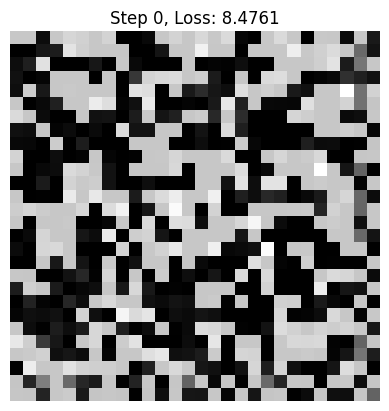

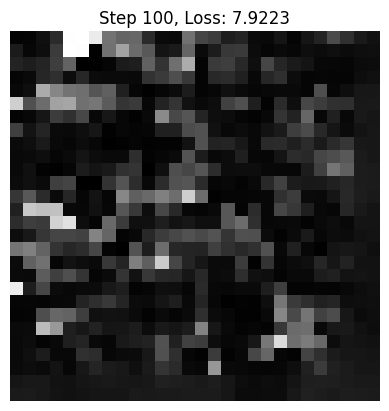

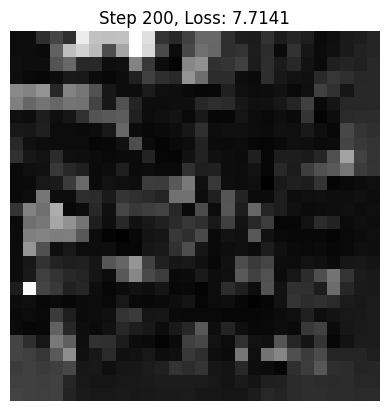

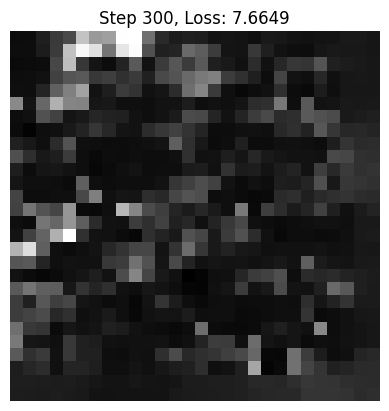

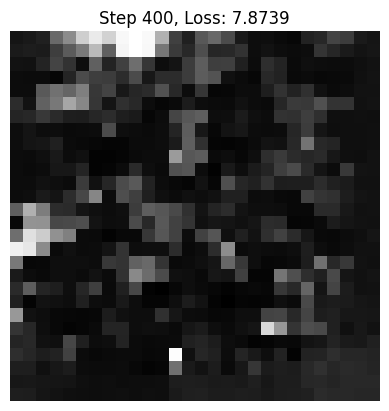

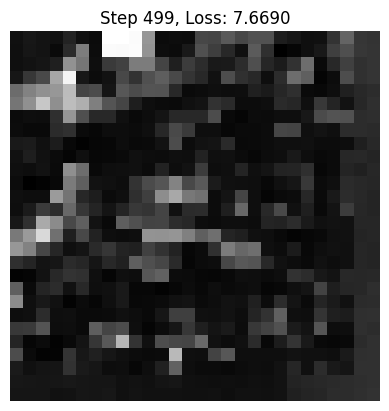

In [13]:
import matplotlib.pyplot as plt

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

# Optimization loop (stop early to prevent degradation)
for step in range(500): 
    loss, grads = adam_closure()
    optimizer.apply_gradients(zip(grads, vars_to_optimize))
    
    if step % 100 == 0 or step == 499: 
        plt.imshow(x_hat[0, :, :, 0].numpy(), cmap='gray')
        plt.title(f'Step {step}, Loss: {loss.numpy():.4f}')
        plt.axis('off')
        plt.show()

# **4. Result evaluation**

# 4.1. Intro to the Variational Autoencoder

Wait, the image is completely unrecognizable!

The reason for this is pretty obvious, and it's due to the fact that we used gradient coming out of a federated setting.

As we said before, in distributed settings, the server receives *aggregated gradient updates*, not a single example, but many (in our case the size of the batch is 32); DLG implicitly assumes that the gradients come from one (or at the very most a few) samples, not a full batch; let's repeat the formula we were trying to optimize:

$
\arg\min_{x,y} \left\| \nabla_{\theta} \,\ell\bigl(f_{\theta}(x), y\bigr) - g_{\text{shared}} \right\|_2^2
$

In federated/distributed contexts instead the server (and so the attacker who intercepted the aggregated gradient) sees this:

$
g_{\mathrm{FL}} = \frac{1}{N} \sum_{i=1}^{N} \nabla_{\theta} \, \ell\bigl(f_{\theta}(x_i), y_i\bigr)
$

Where in our case $N = 32$.

This generates what can be called a *"many-to-one collapse"*, where infinitely many sets $x_i$ produce the same averaged gradient and the pixel-space optimization fails (because it has no preference for which solution may be real).

This is what causes the corrupt image; DLG asks itself "what single image could have produced this averaged gradient?", and the answer if obviously "no image could have done it", but still, the optimizer tries finding a pixel-wise barycenter and averaged strokes; the blur we see is not noise, it's just the *true uncertainty of the inverse problem*.

So the question switches back to: "is it really possible to get the input data from those aggregated gradients?" And the answer is still yes.

To do so, we will use a **Variational Autoencoder (VAE)**$^5$, which consists of these 3 parts:

* An encoder that maps images
* A decoder that maps latent samples
* A probabilistic latent space that is smooth and structured

Instead of optimizing over pixels like in DLG,

$
x \in \mathbb{R}^{H \times W},
$

we can optimize over latent variables,

$
z \in \mathbb{R}^{d}, \qquad x = G(z).
$

Therefore, the optimization objective becomes:

$
\min_{z} \;\left\|\nabla_{\theta} \, \ell\!\left( f_{\theta}\!\left( G(z) \right) \right)-g_{\mathrm{FL}}\right\|_2^2.
$

Basically, the VAE enforces a **manifold constraint** (only valid digits are allowed), a strong **inductive bias** (meaning that the generator already has a slight understanding of images in the distribution) and **entropy minimization** (among the aggregated gradient, VAE is able to produce the most probable image under the learned data distribution); all of this collapses the solution space to one sharp digit that explains well the aggregated gradient.

In other words, we can think of this like training another model on a MNIST like dataset (with digits), and then use for the attack by interpreting the aggregated gradient correctly.

Let's start by loading a part of the MNIST dataset:

In [14]:
# Load MNIST and take only 10k samples for speed
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train[..., None]
x_train = x_train[:10000]  # smaller subset

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 4.2. The Encoder: Inference Engine

The task that we give the encoder is to generate a probability distribution of the latent variable $z$ given the input data (the image) $x$.

To do so, we consider this formula: 
$
q_{\phi}(z \mid x)=\mathcal{N}\!\left(z \,\middle|\,\mu(x),\operatorname{diag}\!\big(\sigma^{2}(x)\big)\right).
$

Obviously, the term $N$ means that we are considerin a gaussian (normal) distribution; this is merely a design choice, other distributions can and are used, gaussian is just easier to interpret geometrically (bell curve in many directions).

In the parentheses we find the parameters of the distribution:
$
\left(
z \mid \mu(x), \operatorname{diag}\!\big(\sigma^2(x)\big)
\right)
$

1. Obviously, the first parameter is the mean $\mu(x)$, which indicates the center of the distribution (conceptually the encoder predicts where the latent representation should be, this is the “most likely” latent vector); We consider $\mu(x) \in \mathbb{R}^{2}$, meaning that the latent space$^6$ is two-dimensional, effectively bringing us to the conclusion that each image produces two numbers describing the center of its Gaussian in latent space:
$\mu(x) = \begin{bmatrix} \mu_1(x) \\ \mu_2(x) \end{bmatrix}$
2. The second parameter is indeed the variance $\sigma^2(x)$, which obviously indicates how much the distribution is spread out around the mean; $\operatorname{diag}(\sigma^2(x))$ means that each latent dimension has its own variance (this assumption makes the calculations more efficient in general); the covariance matrix then becomes:
$\operatorname{diag}(\sigma^2(x)) =
\begin{bmatrix}
\sigma_1^2(x) & 0 \\
0 & \sigma_2^2(x)
\end{bmatrix}$

We also notice that the log-variance is parameterized as
$
\log \sigma^{2}(x) = \operatorname{logvar}(x).
$
This is done because the neural network, if we keep $\sigma^2(x)$, can in theory output any number, but we know that the variance needs to be always bigger than 0 (or 0 in case of degenerate distributions); also, because variances can be incredibly small, log-space is more stable for optimization.

The reason that we need the parameters of the distribution is pretty straighforward; basically, without it, we would just produce a single latent vector $z$, which would not give such a smooth and continuos latent space (often with holes and overfitting).

We can imagine the encoder as the model that learns how to describe an image probabilistically.

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.Flatten()
        ])
        self.mu = tf.keras.layers.Dense(latent_dim)
        self.logvar = tf.keras.layers.Dense(latent_dim)
        
    def call(self, x):
        x = self.conv(x)
        return self.mu(x), self.logvar(x)

# 4.3. The Decoder: Generative Model

VAE is trained by maximing this term (also called the objective): $\mathbb{E}_{q_{\phi}(z \mid x)}\!\left[\log p_{\theta}(x \mid z)\right]$; This term asks: “If the encoder gives me a latent description $z$, how likely is the decoder to reproduce faithfully the original data $x$?”.

The **decoder** instead answers the question “If I pick a latent point $z$, how likely is it that the image x would be generated from it?”.

So the decoder defines the conditional probability distribution we saw in the parentheses: $p_{\theta}(x \mid z).$ This is the generative model.

This raises a question, how can the decoder produce its own image? Because the decoder is a neural network of its own, it uses this formula: $\hat{x} = f_{\theta}(z)$ , in which $f_\theta$ associates each latent variable $z$ to the relative output $\hat{x}$.

Because the image pixels are scaled to [0,1], each pixel is treated as a **Bernoulli random variable**; this means that decoder defines $p_{\theta}(x \mid z)=\operatorname{Bernoulli}(\hat{x})$ , which basically says that each pixel has a certain probability of being 1, given $z$.

The decoder finally ends with a sigmoid, so that it respects Bernoulli's rules: $\hat{x}_i \in (0,1)$.

The reason of the log in the main formula for the objective is that the log-likelihood of a Bernoulli distribution leads directly to the binary cross-entropy loss that we need to use.

In easy terms, the decoder simply learns how to draw the image from the encoder's probabilistic latent's description.

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.fc = tf.keras.layers.Dense(28*28*16, activation='relu')
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Reshape((28,28,16)),
            tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
        ])
        
    def call(self, z):
        x = self.fc(z)
        return self.conv(x)

You may also have noticed that the encoder and decoder relation seem dictated from Bayes Rule, and you are correct (in part).

At the end of the day, in bayesian terms, we are trying to estimate the true posterior $p_\theta(z \mid x)$, which we can do with bayes:

$p_\theta(z \mid x) = \frac{p_\theta(x \mid z)\, p(z)}{p_\theta(x)}$,
where
$p_\theta(x) = \int p_\theta(x \mid z)\, p(z)\, dz$.

Because of this integral being basically impossible to reliably calculate (due to the enormous integration space and the complex function to consider) we use $q_{\phi}(z \mid x)$, to approximate the posterior and reutilize it for every image, instead of singlehandedly calculate $p_\theta(z \mid x)$ for each image.

Now let's rewrite the log-similarity introducing the variational distribution $q_\phi(z \mid x)$:

$
\log p_\theta(x)=
\log \int p_\theta(x \mid z)\, p(z)\, dz
$,
and, multiplying and dividing by $q_\phi(z \mid x)$ it becomes
$
\log p_\theta(x)=
\log \int
q_\phi(z \mid x)\,
\frac{p_\theta(x \mid z)\, p(z)}{q_\phi(z \mid x)}
\, dz
$

Now let's apply the *Jensen Inequality*$^7$:

$\log \mathbb{E}[f(z)] \ge \mathbb{E}[\log f(z)]$

Finally we obtain what is called **Evidence Lower BOund (ELBO)**$^8$, which is the quantity we need to maximize:

$\log p_\theta(x) \ge
\mathbb{E}_{q_\phi(z \mid x)}\big[\log p_\theta(x \mid z)\big]-
\mathrm{KL}\big(q_\phi(z \mid x)\,\|\,p(z)\big)$

Where the first term is for reconstruction, and says to us for each $z$ how good it will be it's reconstruction of $x$, while the second term is to measure how much the encoder is distant from the actual prior (also called regularization, to regularize the latent space); you'll see their more practical use later on.

# 4.4. Reconstruction and Regularization

The following (and last) part includes many things.


1. Reparameterization tricks (eps and z), to make the sampling differentiable and let the gradient flow through the gaussian parameters (mean and standard deviation).
2. It includes the **reconstruction loss** (recon_loss), in which, as we explained before, the encoder compresses image into z while the decoder tries to rebuild the image from z; in simpler words, recon_loss punishes unfaithful reconstructions, making sure that z will learn to contain more useful informations about x.
3. We also add **KL divergence** (or **regularization**), which basically says “no matter what the input is, its latent distribution should look like a standard normal”; this makes it so the model doesn't just overfit and memorize random data and digits, while it forces all latent codes to live in the same region.


Finally, we also add the total VAE loss (which obviously is just -ELBO, because by maximizing it, we can decrease the loss):

$
\mathcal{L}_{\mathrm{VAE}}=\underbrace{-\,\mathbb{E}_{q_{\phi}(z \mid x)}\big[\log p_{\theta}(x \mid z)\big]}_{\text{reconstruction}}\;+\;\underbrace{\mathrm{KL}\!\left(q_{\phi}(z \mid x)\,\|\,p(z)\right)
}_{\text{regularization}}.
$

Thanks to the gradient training step we can update both encoder and decoder parameters.

All of this is especially cool because, thanks to the KL divergence term, we enforced:
$
q_{\phi}(z \mid x) \approx \mathcal{N}(0, I),
$

and now we can sample latent variables from the prior:
$
z \sim \mathcal{N}(0, I),
$

This effectively means that we can generate new data via the decoder:
$
x \sim p_{\theta}(x \mid z).
$

Basically we just gave the model the freedom it needs to generate a completely original image statistically similar to the distribution we gave it (in our case, it will be able to generate original digits by learning from the MNIST dataset); this probably already makes you understand why even not being able to replicate exact training input data is still so scary!

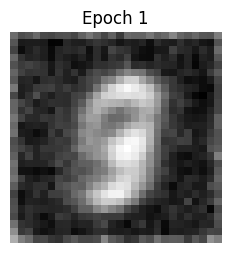

Epoch 1, Loss: 0.3831


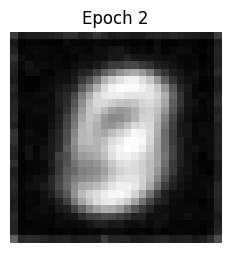

Epoch 2, Loss: 0.2982


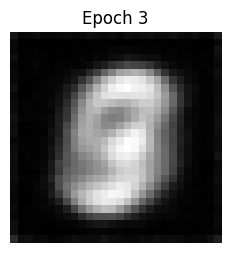

Epoch 3, Loss: 0.2613


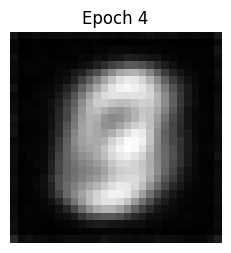

Epoch 4, Loss: 0.2671


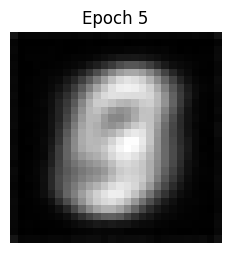

Epoch 5, Loss: 0.2708


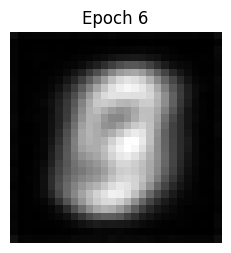

Epoch 6, Loss: 0.2806


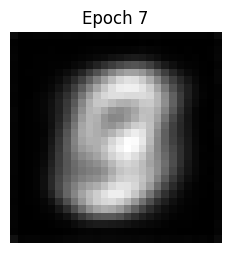

Epoch 7, Loss: 0.2904


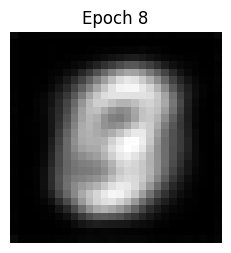

Epoch 8, Loss: 0.2461


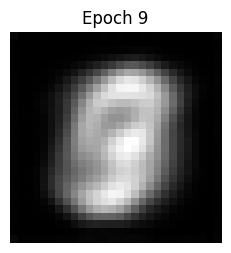

Epoch 9, Loss: 0.2413


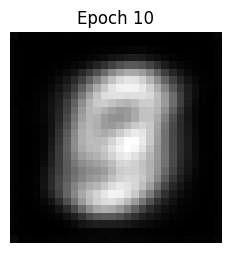

Epoch 10, Loss: 0.2792


In [17]:
encoder = Encoder()
decoder = Decoder()
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        mu, logvar = encoder(x)
        eps = tf.random.normal(shape=mu.shape)
        z = mu + tf.exp(0.5*logvar) * eps
        x_hat = decoder(z)
        recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_hat))
        kl_loss = -0.5 * tf.reduce_mean(1 + logvar - mu**2 - tf.exp(logvar))
        loss = recon_loss + kl_loss
    grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return loss

viz_batch = next(iter(dataset))

for epoch in range(10):  # just 3 epochs for demo
    for x in dataset:
        loss = train_step(x)

    # Visualization
    mu, logvar = encoder(viz_batch)
    eps = tf.random.normal(shape=mu.shape)
    z = mu + tf.exp(0.5 * logvar) * eps
    x_hat = decoder(z)

    plt.figure(figsize=(6, 3))

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(x_hat[0, :, :, 0], cmap='gray')
    plt.title(f"Epoch {epoch+1}")
    plt.axis('off')

    plt.show()

    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

In this case, the image we get is obviously not that clear (at the end of the day we are basically looking for a single digit in a gradient aggregated by a batch of 32 samples!); still, we get clear info out of this image, which resembles more "curved" numbers, more specifically like an 8 or 9, so we can assume those are the most prevalent in the aggregated distribution.

# 4.5. Ok, but why is this a big deal? Behind a privacy breach

So, at last, we were able to get ahold of the most likely data manifold explanation of the gradient!

But wait, how is this useful for an attacker? The fact is, privacy is not always about exact sample recovery; this is because **recovering distributional information is already a privacy violation**.

For instance, imagine an attacker gets the leaked gradients from a cross-silo setup between hospitals, and he knows the input images were MRI scans; knowing this, he can train the VAE (encoder and decoder) on a public MRI scans dataset, so that, if played right, he could get the most probable explanation for the aggregated gradient.

The reconstructed image may not be Filippo’s MRI, but it is a valid MRI, consistent with the private cohort and reveales sensitive structure (tumor shape, brain region, pathology).

This violates:

* attribute privacy
* distribution
* privacy
* population privacy

Which is enough to break HIPAA/GDPR-style assumptions.

In many threat models knowing what kind of data was used and knowing its anatomical or semantic structure is far more dangerous than knowing exact pixels for a single patient.

# 4.6. A system's insight

Obviously, being this a notebook, it doesn't fully reflect some events that could (and some are even common) in a real system.

1. **DEVICEvsSILO**: The first distinction worthy of raising is the difference between a Cross-device and a Cross-Silo system. While we already explained it in more detail in the NON-IID data notebook, this distinction is especially fundamental, as it completely changes the system perspective altogether. For instance, let's consider two different instances to apply the attack:
 * In a cross-device context (think for example of Google Keyboard, IoT...) we often have milions of clients, each with only an exponentially small amount of data, with heavily noisy gradients, usually with stronger defences like Secure Aggregation (and often dropouts of all kind). All of this makes gradient inversion attacks much more complicated
* In a cross-silo setup (think for example banks or hospitals) instead there are less clients (but more trustworthy), with much more information detained by each one, with more informative gradients, more often than not with even less defences. All of this means that our inversion attack is much more realistic if we take a cross-silo setup as the system at hand.     

2. **COMMUNICATION ROUNDS**: Let's remember that Federated Learning (and all other kinds of distributed systems) is not just a single exchange of gradients, but an iteractive process. This means that for each communication round the server sends the model, the clients calculate their gradient, the server aggregates them all and finally it updates the model, ready for another round to happen. Why is this important though? well, because of this fact an attacker usually relies on **cumulative leakage**, which is basically the more technical wording for "More Rounds = More Information = More Accurate Reconstruction". This is because the attacker can correlate gradients in the time the updates happen, reconstruct recurrent patterns and even utilize differences between rounds to isolate single contributions in the model (effectively meaning technically obtaining a single example in the aggregation). Basically, in our case, we used a single round, but in reality, if the attacker has access to the aggregated gradients during those rounds, then the attack will likely be even more dangerous.

3. **CLIENT SAMPLING**: In real distributed systems, not every assigned client will participate in the round (for example due to dropout, more specifically low connection or battery); this introduces systemic vulnerabilities. For instance, if a client X appears only in a few rounds then our server could potentially isolate its contributions, confront rounds with and without that single client, subtract aggragated gradients, and even, in the worst case scenario, obtain an almost single gradient. This means that the potential assurance of the images being aggregated gets completely bypassed.

4. **MODEL ARCHITECTURE & HETEROGENEITY**: In real systems the models are often enormous, clients have different hardware, and gradients are not always equal in structure (some are compressed, some are quantized...). All these factors influence the quality of the leakage, the feasibility of the gradient inversion and the necessity of using VAE or even stronger priors (such as *GANs (Generative Adversarial Networks)*$^9$).

# 4.7. MNIST Digits vs MRI Scans

One wrong assumption I initially made is thinking that MNIST would actually be the best dataset to test the gradient inversion. I am probably at fault for following the line of thinking "if it's an easy classifier then it will also be easy for gradient inversion!", even though it couldn't be further from the truth. In fact, if we value the nature of the problem we come to the conclusion that more privacy-dependent and at first impact more "difficult" datasets (for instance, a group of MRI scans) are actually easier to invert and obtain even clearer image, violating privacy guarantees of the system in a more plausible way.

This is mainly because of **variability**$^{10}$. 

For us humans, classifying the MNIST digits is incredibly easy, but for the computer it is not, and sometimes we don't understand that the number 0 to 9 are incredibly diverse structurally; each class has very different traits, different styles, different inclination, and as we mentioned a batch of 32, which effectively means a mix of completely incompatible forms. This results in the aggregated gradient being a mixture of random signals, DLG fails, and even VAE is only able to produce a plausible digit, but not a really nitid one.

If we now consider a batch of MRI scans we notice that they are actually way more structured and with less variability. This is because in the batch the anatomy is the same (everyone has a brain), every image has the same orientation (sagittal axis), same resolution and scale, and even same local variations (e.g. tumors, lesions, oedema...). This in turn means that the aggregated gradient is not just a mixture of incompatible forms, rather a mean of very similar images (we say that the aggregated gradient preserves the anatomical structure).

All of this suggests that the prior on MRI is way more powerful than the experiment we tried here. A VAE (or diffusion model) trained on MRI scans knows the brain shape, knows where the ventricules, cortex and medulla are, and knows how tumors, lesion or other anomalies appear. This adds to what we said earlier, even with aggregated gradients, the prior can reconstruct a plausible brain shape, include a mass if the gradient suggests it and also reveal the patological distribution of the entire batch.

Even then, as we mentioned previously, the goal isn't a perfect reconstruction of a single sample, but an informative reconstruction. We don't really care about X's MRI scan, but the reconstruction showing the brain with a lesion in the frontal lobe, a mass consistent with a glioma and a structure that is consistent with the private cohort is already a massive privacy breach that violates:
* Distribution privacy (e.g. we discover the dataset is pediatric)
* Attribute privacy (e.g. has a tumor)
* Population privacy (e.g. the cohort has early-onset Alzheimer's disease)

# **5. What's next**

We arrived at the conclusion that the implicit aggregation that distributed and federated learning systems apply to the gradients is not enough to protect private data.

To do so, we will need to apply SotA techniques, such as Secure Aggregation or Differential Privacy techniques (such as gaussian noise).

# Definitions

**Federated Learning**: A machine learning technique based on a decentralized learning system to avoid centralizing private data, shifting the privacy risk from both the client and the server/cloud to the client side only.

**DLG**: Deep Leakage from Gradients, first introduced in [this paper](http://papers.nips.cc/paper_files/paper/2019/hash/60a6c4002cc7b29142def8871531281a-Abstract.html), it showed how you can reliably obtain the original image from the gradient.

**iDLG**: Improved Deep Leakage from Gradients, utilizes more advanced techniques (such as exploiting a direct relationship between the gradient of the bias in the final layer and the true label) to maximize the reconstruction potential.

**"Honest-but-curious" server**: or semi-honest server, is a server which follows its protocol exactly (honest), but quietly tries to learn as much as it can from the data while doing it's job (curious, you could even say it's nosy). It's widely used in security as it becomes imperative encrytpting and defending the data, so that the server can do its job without truly understanding the private information it works with.

**VAE**: Variational AutoEncoder; It consists of *Encoder* (the model that does inference to find the probability distribution of the latent variable z given the image x) and *Decoder* (the generative model, that is able to generate a plausible image from the statistical latent's description given by the encoder).  VAE works by enforcing a *manifold constraint* (only valid digits are allowed), a strong *inductive bias* (meaning that the generator already has a slight understanding of images in the distribution) and *entropy minimization* (among the aggregated gradient, VAE is able to produce the most probable image under the learned data distribution); all of this collapses the solution space to one sharp digit that explains well the aggregated gradient.

Think of the VAE-based attack as a Bayesian posterior inference problem:

$
p(x \mid g_{\mathrm{FL}})
\;\propto\;
p(g_{\mathrm{FL}} \mid x)\, p_{\mathrm{VAE}}(x)
$

DLG $\approx$ maximum likelihood without a prior

VAE inversion $\approx$ MAP inference with a strong prior

Aggregation weakens the likelihood, but the prior still dominates.

**Latent Space**: The latent space is a compressed, meaningful, smooth representation of data (like images in our case) that a model learns internally. If we want to reconstruct images from gradients they become fundamental; if we optimize pixels directly we get weird blobs, half-digits, noisy artifacts, while if we instead optimize the latent variables then the generator only outputs valid digits, the search space is smaller, the optimization is smoother and as a result the final result is in general sharper and more realistic.

**Jensen's Inequality**: It's the inequality that explains how nonlinear functions interact with expectations; it's behavior depends on the function:
* if the function is concave (think of logx): $\log \mathbb{E}[X] \ge \mathbb{E}[\log X]$
* if the function is convex (think of $x^2$), the inequality flips: $(\mathbb{E}[X])^2 \le \mathbb{E}[X^2]$

In practice it works as a trick; instead of calculating taking the log after integrating, it allows to take the log before integrating, making the integration easier. Basically, it works as the lower bound for the optimization.

**ELBO**: Evidence Lower BOund is a safe underestimate of how accurate our produced data is; basically, because as we already said many times we can't really compute the true likelihood, we can use Jensen, which gives us a number to compute our likelihood with, while also telling us that it need to be less than or equal to the true answer (lower bound) and the closer we are the more correct the approximation is.

**GANs**: Generative Adversarial Network, is a way to teach a computer what real data looks like by making two neural networks compete with each other; one network creates examples and the other network judges them.
Through that competition, the creator learns to make data that looks real.

GANs can actually be used for gradient inversion purposes, and they are even considered stronger priors than VAEs and other diffusion models; this is for some main differences:
1. The first huge difference is *determinism*; GANs are completely deterministic (for same z equals the same x, which means more clean gradient flow), while VAEs, as we saw, involves sampling, inference, noise in reconstruction and gradients estimation.
2. In the GAN-based inversion we are optimizing just a small latent vector, while in VAE-based inversion we are often optimizing the variable z, reconstruction noise and even potential encoder mismatch (all of this makes the process of the optimization in general much messier and less efficient).
3. GANs models also dominate in other fields, such as output sharpness, latent space geometry and prior strength (in GAN only outputs that look real are allowed, while in VAE anything close to the data distribution is allowed).

All of these advantages could give the impressione that GANs are actually better in any scenario, but this is just not true; GAN assumes outputs are sharp, well-aligned on the manifold which, as we saw in the section 4.7. MNIST Digits vs MRI Scans, in our case (MNIST) is just not true, as our manifold is composed of incredibly different digits, meaning the statistically more common manifold is everything but sharp. GANs instead shine for example in MRI Scans, where the data has a strong anatomical structure or regularity, ergo we don’t need the generator to handle huge variation.

**Variability**: In this case, variability refers to the differences between each image possible in the batch. As we said previously, digits datasets show a way higher variability than MRI scans, whcih preserve the same anatomical structure for each scan.